# 阶跃星辰文生图 API 使用指南（Jupyter Notebook）

本 Notebook 基于阶跃星辰文生图 API 文档（[https://platform.stepfun.com/docs/guide/image_generate](https://platform.stepfun.com/docs/guide/image_generate)）编写，包含基础调用、参数配置、高级功能等实操示例，帮助开发者快速集成文生图能力。

## 1. 环境准备

首先安装依赖的 Python 库，API 调用基于 OpenAI SDK 实现。

In [ ]:
# 安装OpenAI SDK
!pip install openai --upgrade

## 2. 基础配置

设置 API 密钥、模型名称等核心配置，**请替换为你的实际 STEP_API_KEY**。

In [61]:
from openai import OpenAI
import os

# 核心配置
STEPFUN_KEY = os.getenv("STEPFUN_API_KEY") # 替换此处为你的API密钥
STEPFUN_MODEL = "step-1x-medium"   # 阶跃星辰文生图模型
BASE_URL = "https://api.stepfun.com/v1"  # API基础地址

# 初始化客户端
client = OpenAI(api_key=STEPFUN_KEY, base_url=BASE_URL)

## 3. 基础文生图调用

支持两种返回格式：`url`（图片链接）和`base64`（编码数据），可根据业务场景选择。

### 3.1 返回 URL 格式

生成图片后返回临时 URL，需下载后存储（URL 有失效时间，不可直接用于用户展示）。

In [29]:
def generate_image_url(
    prompt,
    model=STEPFUN_MODEL,
    n=1,
    size="1024x1024",
    steps=50,
    seed=0,
    cfg_scale=7.5
):
    """生成图片并返回URL格式结果"""
    response = client.images.generate(
        model=model,
        prompt=prompt,
        response_format="url",  # 指定返回URL
        extra_body={"cfg_scale": cfg_scale, "seed": seed, "steps": steps},
        size=size,
        n=n  # 生成图片数量
    )
    return response.data

# 示例：生成古诗意境图
if __name__ == "__main__":
    prompt = "采菊东篱下，悠然见南山。—— 田园风格，水墨质感，淡雅色调"
    image_results = generate_image_url(prompt)
    
    # 输出结果（包含图片URL）
    for idx, img in enumerate(image_results):
        print(f"图片{idx+1} URL: {img.url}")
        # 提示：可使用requests库下载图片到本地或对象存储

图片1 URL: https://res.stepfun.com/image_gen/20251118/019a95ed76807213922ad3b54eefe92d.png?X-Tos-Algorithm=TOS4-HMAC-SHA256&X-Tos-Credential=AKLTMmVmYjcxNDdhZWE4NDU4NzllMTc1MmIyMGUzYzBlYWY%2F20251118%2Fcn-shanghai%2Ftos%2Frequest&X-Tos-Date=20251118T074558Z&X-Tos-Expires=3600&X-Tos-Signature=d7fd712469cb4031cdae08f00cc5e7ff6c59d643a5a188de97823475198ee53e&X-Tos-SignedHeaders=host


### 3.2 返回 Base64 格式

生成图片的 Base64 编码，可直接解码为图片文件存储。

生成第 1 张图片…
使用的 seed：1914328277
已保存：./media/05_image_1.png


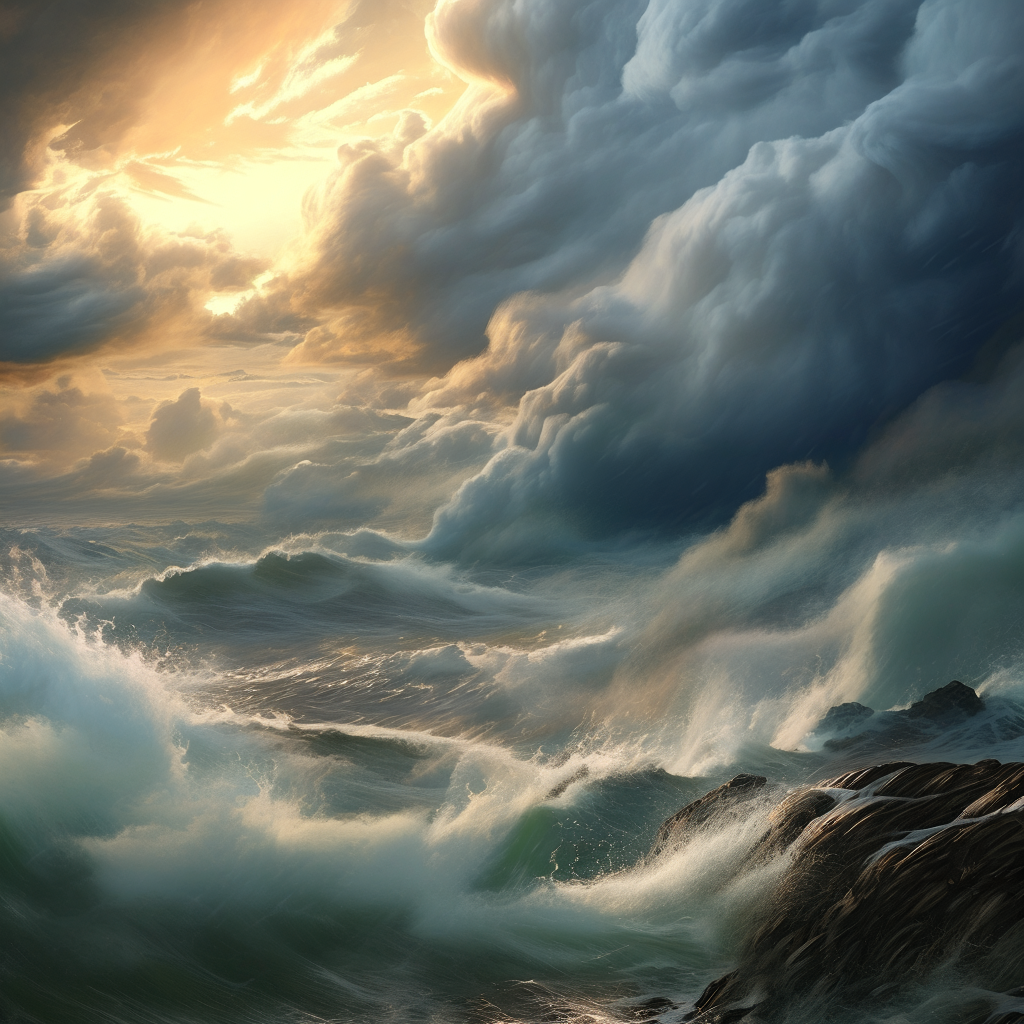

生成第 2 张图片…
使用的 seed：628034095
已保存：./media/05_image_2.png


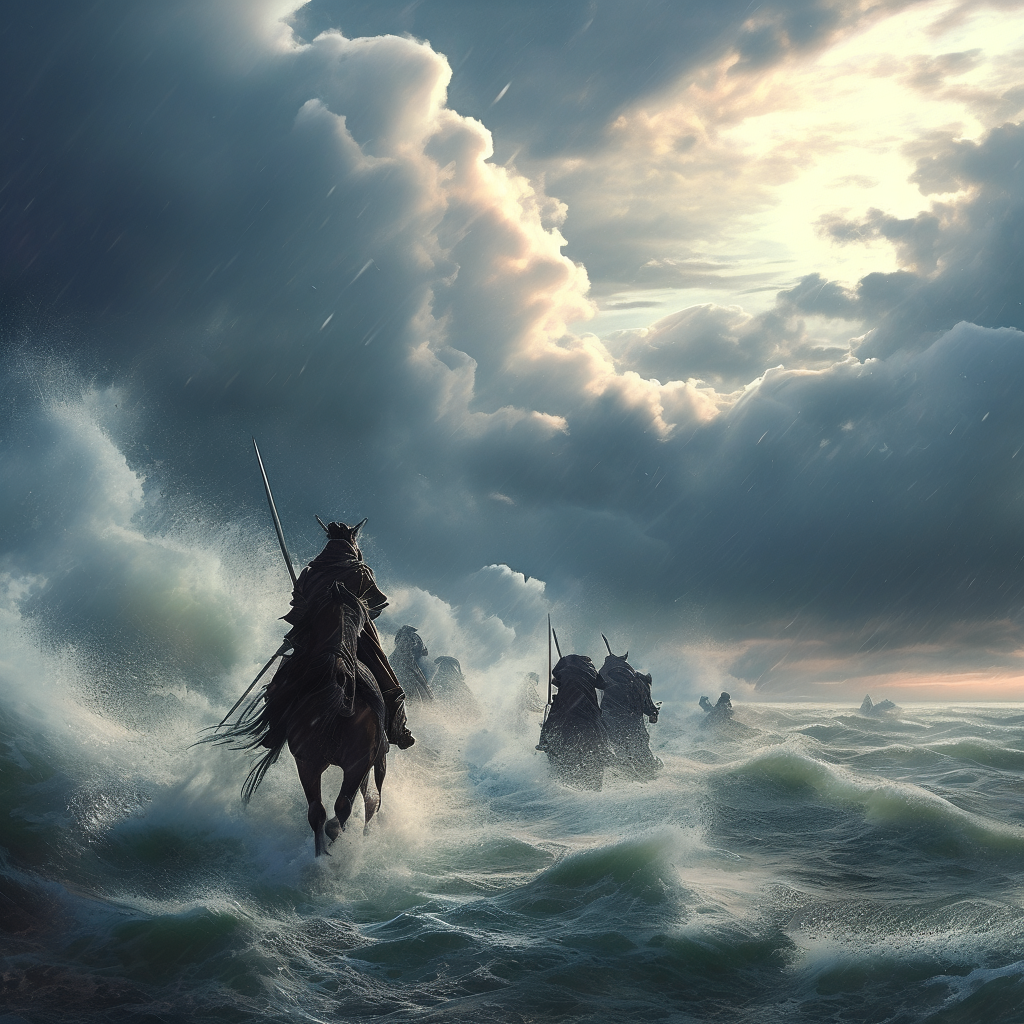

In [ ]:
import base64
import time
from IPython.display import Image, display

def generate_image_base64(
    prompt,
    model=STEPFUN_MODEL,
    size="1024x1024",
    steps=80,
    seed=0,
    cfg_scale=8
):
    response = client.images.generate(
        model=model,
        prompt=prompt,
        response_format="b64_json",
        size=size,
        extra_body={
            "cfg_scale": cfg_scale,
            "seed": seed,
            "steps": steps
        }
    )
    return response.data

prompt = """
大风起兮云飞扬，威加海内兮归故乡。安得猛士兮守四方！
"""
num_images = 2

for i in range(num_images):
    print(f"生成第 {i+1} 张图片…")
    
    results = generate_image_base64(prompt, seed=0)
    img_b64 = results[0].b64_json

    # 输出返回的 seed
    if hasattr(results[0], "seed"):
        print(f"使用的 seed：{results[0].seed}")

    image_data = base64.b64decode(img_b64)
    filename = f"./media/05_image_{i+1}.png"
    with open(filename, "wb") as f:
        f.write(image_data)

    print(f"已保存：{filename}")
    display(Image(data=image_data))

    time.sleep(0.2)


## 4. 高级功能：垫图生成

基于已有图片进行二次生成，支持随机重生成、细节增强、小范围修改等场景，核心参数为`source_weight`。当 source_weight 为 1 时，为图像完全重新生成，垫图将不起任何作用。

### 4.1 垫图参数参考

| 预期功能     | Prompt 要求                       | source_weight 建议 | 备注                        |
| -------- | ------------------------------- | ----------------- | ------------------------- |
| 图像随机重新生成 | 尽量还原原图描述                        | 0.8 ～ 1.0         | 保留原图核心内容，风格随机             |
| 细节增强     | 还原原图描述 + 质量词（如 finely detailed） | 0 ～ 0.5           | 提升画质，保留原图主体               |
| 小范围修改    | 明确写出修改内容                        | 0.3 ～ 0.8         | 易出现异常，大规模修改建议用 Image Edit |

### 4.2 垫图生成示例

需先将垫图转换为 Base64 编码，再传入 API 参数。

In [90]:
import requests

def image_to_base64(image_path_or_url):
    """将图片文件或URL转换为Base64编码"""
    if image_path_or_url.startswith("http"):
        # 从URL获取图片
        response = requests.get(image_path_or_url)
        image_data = response.content
    else:
        # 从本地文件获取图片
        with open(image_path_or_url, "rb") as f:
            image_data = f.read()
    return base64.b64encode(image_data).decode("utf-8")

# 垫图生成示例（需替换垫图路径/URL）
if __name__ == "__main__":
    # 1. 准备垫图（示例：本地图片或网络图片URL）
    # source_image_path = "./media/05_image_1.png"  # 替换为你的垫图路径
    source_image_path = "https://static.stepfun.com/static/platform-docs-prod/docs/_next/static/media/i2iinput.ea2d2a75.png"
    source_image_b64 = image_to_base64(source_image_path)
    
    # 2. 配置参数
    prompt = "chibi风格"
    source_weight = 0.8  # 参考参数表设置
    
    # 3. 调用API
    response = client.images.generate(
        model=STEPFUN_MODEL,
        prompt=prompt,
        response_format="url",
        size="1024x1024",
        extra_body={
            "cfg_scale": 7.5,
            "seed": 0,  #随机一个seed
            "steps": 100,
            "source_image": source_image_b64,  # 垫图Base64编码
            "source_weight": source_weight     # 垫图权重
        }
    )
    
    # 4. 输出结果
    print("垫图生成结果URL:", response.data[0].url)

垫图生成结果URL: https://res.stepfun.com/image_gen/20251119/019a9bc1b31d7032875ce0e256ee715e.png?X-Tos-Algorithm=TOS4-HMAC-SHA256&X-Tos-Credential=AKLTMmVmYjcxNDdhZWE4NDU4NzllMTc1MmIyMGUzYzBlYWY%2F20251119%2Fcn-shanghai%2Ftos%2Frequest&X-Tos-Date=20251119T105554Z&X-Tos-Expires=3600&X-Tos-Signature=5eb99831685faea9b49fdb8bee9721ea6586abcf9d5a5c12a5122d2bc4dec9ce&X-Tos-SignedHeaders=host


## 5. 高级功能：风格参考生成（Sref）

通过 “文本控制内容 + 图片控制风格” 生成图片，核心参数为`style_reference.weight`（默认 1，建议 0.5~1.5）。

In [ ]:
# 风格参考生成示例
if __name__ == "__main__":
    # 1. 准备风格参考图 光线偏暗 紫色调
    style_image_path = "https://images.unsplash.com/photo-1534528741775-53994a69daeb?ixlib=rb-4.0.3&auto=format&fit=crop&w=500&q=80"#"https://plus.unsplash.com/premium_photo-1683147701489-580baa385cae?q=80&w=1740&auto=format&fit=crop&ixlib=rb-4.1.0&&w=1024&q=80" # 替换为你的风格参考图
    
    # 2. 配置参数
    prompt = "一只兔子"  # 内容描述（英文/中文均可）
    style_weight = 1.0  # 风格权重
    
    # 3. 调用API
    response = client.images.generate(
        model=STEPFUN_MODEL,
        prompt=prompt,
        response_format="url",
        size="1024x1024",
        extra_body={
            "cfg_scale": 7.5,
            "steps": 50,
            "style_reference": {
                "source_url": style_image_path,    # 风格参考图
                "weight": style_weight       # 风格权重
            }
        }
    )
    

    # 4. 输出结果
    print("风格参考生成结果URL:", response.data[0].url)

风格参考生成结果URL: https://res.stepfun.com/image_gen/20251119/019a9bbbf0b67f35845b33a6082955d9.png?X-Tos-Algorithm=TOS4-HMAC-SHA256&X-Tos-Credential=AKLTMmVmYjcxNDdhZWE4NDU4NzllMTc1MmIyMGUzYzBlYWY%2F20251119%2Fcn-shanghai%2Ftos%2Frequest&X-Tos-Date=20251119T104936Z&X-Tos-Expires=3600&X-Tos-Signature=957ee0b6bb1ea356d9431e3418c8ac607bf4c03609eff07d55539a43f05eff14&X-Tos-SignedHeaders=host


## 6. 参数优化与配置

### 6.1 调整生成分辨率

支持正方形（1:1）和长方形（16:9）分辨率，分辨率越大生成越慢。

可选分辨率：

*   正方形：256x256、512x512、768x768、1024x1024

*   长方形：1280x800（横屏）、800x1280（竖屏）

In [91]:
# 示例：生成竖屏图片（800x1280）
if __name__ == "__main__":
    prompt = "山间瀑布，飞流直下，古风插画"
    response = client.images.generate(
        model=STEPFUN_MODEL,
        prompt=prompt,
        response_format="url",
        size="800x1280",  # 设置竖屏分辨率
        extra_body={"steps": 50, "cfg_scale": 7.5}
    )
    print("竖屏图片URL:", response.data[0].url)

竖屏图片URL: https://res.stepfun.com/image_gen/20251119/019a9bc204257bfc97a07a782bb0d948.png?X-Tos-Algorithm=TOS4-HMAC-SHA256&X-Tos-Credential=AKLTMmVmYjcxNDdhZWE4NDU4NzllMTc1MmIyMGUzYzBlYWY%2F20251119%2Fcn-shanghai%2Ftos%2Frequest&X-Tos-Date=20251119T105614Z&X-Tos-Expires=3600&X-Tos-Signature=2662983b073e6e865e37c782b354cb3ad0fc53ad9d511ab54f1446f0ff2603d7&X-Tos-SignedHeaders=host


### 6.2 优化生成速度

`steps`（生成步数）和`size`（分辨率）直接影响生成速度，可根据业务需求权衡。


*   `steps`：越大质量越好，速度越慢（建议 30~80）

*   `size`：越小速度越快，细节越少

In [92]:
# 示例：快速生成低步数图片（适合实时场景）
if __name__ == "__main__":
    prompt = "一只可爱的柯基犬，坐姿，简单背景"
    response = client.images.generate(
        model=STEPFUN_MODEL,
        prompt=prompt,
        response_format="url",
        size="512x512",  # 小分辨率
        extra_body={"steps": 30, "cfg_scale": 7.0}  # 低步数
    )
    print("快速生成结果URL:", response.data[0].url)

快速生成结果URL: https://res.stepfun.com/image_gen/20251119/019a9bc23f1074c28f0734f882217f68.png?X-Tos-Algorithm=TOS4-HMAC-SHA256&X-Tos-Credential=AKLTMmVmYjcxNDdhZWE4NDU4NzllMTc1MmIyMGUzYzBlYWY%2F20251119%2Fcn-shanghai%2Ftos%2Frequest&X-Tos-Date=20251119T105629Z&X-Tos-Expires=3600&X-Tos-Signature=36aaeab80fdb0c955e698b1bd01f4be29993701decf0c7ac3fb5cdf47b68454f&X-Tos-SignedHeaders=host


### 6.3 持续生成相同风格图片

固定`seed`值（随机数种子）可保持生成风格一致，适合用户迭代调整 Prompt 的场景。

In [93]:
# 示例：固定seed生成相同风格的图片
if __name__ == "__main__":
    # 1. 首次生成（可记录返回的seed，或自行指定）
    fixed_seed = 123456  # 自行指定固定seed
    
    # 2. 第一次生成（Prompt：春日樱花）
    prompt1 = "春日樱花树下的长椅，日系漫画风格"
    res1 = client.images.generate(
        model=STEPFUN_MODEL,
        prompt=prompt1,
        response_format="url",
        size="1024x1024",
        extra_body={"seed": fixed_seed, "steps": 50}
    )
    print("风格基准图URL:", res1.data[0].url)
    
    # 3. 第二次生成（调整Prompt，保持风格）
    prompt2 = "秋日枫叶树下的长椅，日系漫画风格"  # 修改场景，保留风格
    res2 = client.images.generate(
        model=STEPFUN_MODEL,
        prompt=prompt2,
        response_format="url",
        size="1024x1024",
        extra_body={"seed": fixed_seed, "steps": 50}  # 复用相同seed
    )
    print("同风格调整图URL:", res2.data[0].url)

风格基准图URL: https://res.stepfun.com/image_gen/20251119/019a9bc2c1dc7c2bab9bbced2f28f294.png?X-Tos-Algorithm=TOS4-HMAC-SHA256&X-Tos-Credential=AKLTMmVmYjcxNDdhZWE4NDU4NzllMTc1MmIyMGUzYzBlYWY%2F20251119%2Fcn-shanghai%2Ftos%2Frequest&X-Tos-Date=20251119T105703Z&X-Tos-Expires=3600&X-Tos-Signature=d2f3cf2aaf107cc921f015adf1dddd5da7a69eee9c8ef91a40fc488bd06f03c7&X-Tos-SignedHeaders=host
同风格调整图URL: https://res.stepfun.com/image_gen/20251119/019a9bc2dc2c7ef890952870fefe668c.png?X-Tos-Algorithm=TOS4-HMAC-SHA256&X-Tos-Credential=AKLTMmVmYjcxNDdhZWE4NDU4NzllMTc1MmIyMGUzYzBlYWY%2F20251119%2Fcn-shanghai%2Ftos%2Frequest&X-Tos-Date=20251119T105710Z&X-Tos-Expires=3600&X-Tos-Signature=8d22a18729b5e838064ce5403787703a385bd49698d1c31b8d189a31419bc896&X-Tos-SignedHeaders=host


## 7. 错误处理

添加异常捕获逻辑，提升应用健壮性。

In [94]:
def generate_image_safe(prompt, size="1024x1024"):
    """带错误处理的图片生成函数"""
    try:
        response = client.images.generate(
            model=STEPFUN_MODEL,
            prompt=prompt,
            response_format="url",
            size=size,
            extra_body={"steps": 50, "cfg_scale": 7.5}
        )
        return {"success": True, "data": response.data}
    except Exception as e:
        # 捕获常见异常：API密钥错误、参数无效、请求频率超限等
        return {"success": False, "error": str(e)}

# 示例：测试错误处理
if __name__ == "__main__":
    # 测试1：正常请求
    normal_prompt = "蓝天白云，草原骏马"
    result1 = generate_image_safe(normal_prompt)
    print("正常请求结果:", "成功" if result1["success"] else "失败")
    
    # 测试2：无效分辨率（故意传入错误参数）
    invalid_prompt = "测试图片"
    result2 = generate_image_safe(invalid_prompt, size="2000x2000")  # 无效分辨率
    print("无效参数请求结果:", "成功" if result2["success"] else f"失败，原因：{result2['error']}")

正常请求结果: 成功
无效参数请求结果: 失败，原因：Error code: 400 - {'error': {'message': 'Request param: size is invalid, recommended val is: must be 256x256,512x512,768x768,1024x1024,1280x800,800x1280', 'type': 'input_invalid'}}


## 8. 注意事项


1.  **API 密钥安全**：切勿将`STEPFUN_KEY`硬编码到前端代码或公开仓库，建议通过环境变量加载。

2.  **URL 时效性**：返回的图片 URL 有时间限制，需及时下载并存储到本地 / 对象存储（如 OSS）。

3.  **参数范围**：`cfg_scale`建议 1~15（控制 Prompt 遵循度），`steps`建议 20~100（平衡质量与速度）。

4.  **功能边界**：垫图生成不适合大规模修改或人脸保持，此类需求建议使用 Image Edit 或 Cref 功能。

## 附录：核心参数说明


| 参数名                      | 作用            | 可选值 / 建议范围      |
| ------------------------ | ------------- | --------------- |
| `prompt`                 | 图片内容描述        | 清晰、具体（支持多语言）    |
| `model`                  | 生成模型          | step-1x-medium  |
| `response_format`        | 返回格式          | url / b64_json |
| `size`                   | 图片分辨率         | 见 6.1 节         |
| `steps`                  | 生成步数          | 30~80          |
| `seed`                   | 随机种子（控制风格一致性） | 0（随机）或自定义整数     |
| `cfg_scale`              | Prompt 遵循度    | 1~15           |
| `source_weight`          | 垫图权重          | 0~1.0          |
| `style_reference.weight` | 风格参考权重        | 0.5~1.5        |
